100%|██████████| 9.91M/9.91M [00:01<00:00, 5.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


Epoch 01/10 | Train Acc: 86.50% | Test Acc: 91.13%


Epoch 02/10 | Train Acc: 92.71% | Test Acc: 92.60%


Epoch 03/10 | Train Acc: 93.69% | Test Acc: 93.39%


Epoch 04/10 | Train Acc: 94.26% | Test Acc: 93.95%


Epoch 05/10 | Train Acc: 94.47% | Test Acc: 94.33%


Epoch 06/10 | Train Acc: 94.80% | Test Acc: 93.72%


Epoch 07/10 | Train Acc: 94.83% | Test Acc: 94.52%


Epoch 08/10 | Train Acc: 94.97% | Test Acc: 94.53%


Epoch 09/10 | Train Acc: 95.08% | Test Acc: 94.92%


Epoch 10/10 | Train Acc: 95.29% | Test Acc: 95.15%


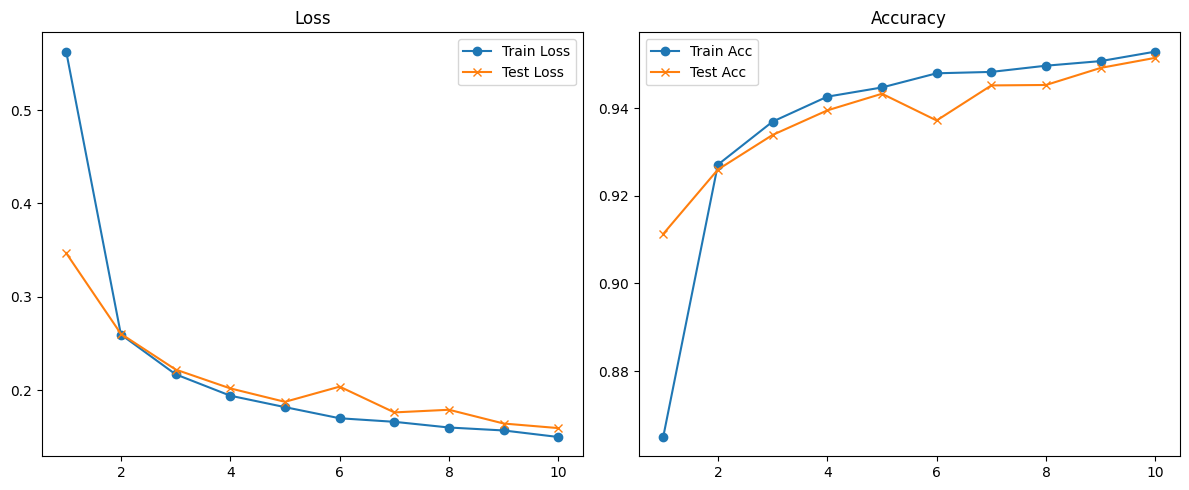

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
num_epochs = 10
learning_rate = 0.001

transform_train = transforms.Compose([
    transforms.Resize(224),           
    transforms.Grayscale(3),             
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    test_loss, test_acc = evaluate(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")

os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/resnet18_mnist.pth')

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc', marker='o')
plt.plot(epochs, test_accs, label='Test Acc', marker='x')
plt.legend(); plt.title("Accuracy")

plt.tight_layout()
plt.savefig('training_curves_resnet18_mnist.png')
plt.show()
